First things first.  We need some data from AWS, and some code from git.  Do this in your terminal, in the tutorial directory:
    
    git clone https://github.com/smithb/PointDatabase.git    
    git clone https://github.com/suzanne64/ATL11.git

Then do this in your home directory:

    aws s3 cp s3://pangeo-data-upload-oregon/icesat2/elevation_change_tutorial /home/jovyan/ATL11 --recursive
    cd ATL11
    tar zxvf ATL11_out.tgz

... and we'll use the numpy and matplotlib packages for data handling and plotting:

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import re

# make sure we're dealing with the most recent version of any code we're using
%load_ext autoreload
%autoreload 2


...Now, on to the tutorial...
# 1. ICESat-2 elevation-change schemes


## 1.1 ATL11
Recall from Monday that the ICESat-2 beam pattern and orbit are designed to measure elevation changes based on along-track elevation differences. 

Each time ICESat-2 repeats its reference tracks, it makes two sets of measurments, spaced 90 m apart.  The height difference between these measurements defines the across-track slope, so the height at any point between these two measurements can be interpolated.  This scheme is easy to describe, for two sets of measurements, but becomes more complicated when multiple repeats over the same track become available.  The planned ATL11 product (Land Ice H(t)) uses multiple repeats of the same RPT to define a time-series of elevation values, interpolated (or extrapolated) to a set of reference points on (or close to) the RPTs.  It does this by defining a low-order polynomial surface that fits the highest-quality subset of the data available around each reference point.  This polynomial surface is then used to correct the elevations from each cycle of measurements over the RPT back to the reference point.  This reference surface is also used to correct data from crossing tracks, so that ATL11 files contain both repeat-track and crossover elevation differences.

One problem with ATL11, as of June, 2019, is that only one cycle of data has been processed that includes data pointed exactly at the RGTs.  This means that we can generate ATL11 products, but they contain at most one cycle of data from the RPTs, plus whatever crossover elevations are available from other tracks.  We will look at a few of these data, and use the ATL11 software package to generate some crossover time series for Pine Island Glacier in West Antarctica.


### 1.Diversion: Class-based data structures

My previous tutorial for ATL06 used a dictionary-based data format within Python.  For this tutorial I'll be using a software package that I use for my own work with ICEsat-2 data.  This is contained in the github repos:

smithb/PointDatabase

suzanne64/ATL11

We cloned these in the first cell.

Python classes let you combine data and code into the same object: It's like data that knows how to do things.  This sounds like a mess, but it can make notation a lot easier.  For our purposes, you use the code and the data in the same way, with 'dot notation,' where you follow the name of the object instance with a dot and then the name of the data field, or function, that you want to access.  

### Back to looking at data
Let's pull in an ATL06 file and see what it looks like.

In [4]:
from PointDatabase import ATL06_data
import ATL11

D6=ATL06_data(beam_pair=2).from_file("/home/jovyan/ATL11/processed_ATL06_20190205041106_05910210_001_01.h5")

To see what's in ATL06, we can look at it with Python's "dir" function

In [5]:
dir(D6)

['BP',
 'LR',
 '__class__',
 '__default_field_dict__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__update_size_and_shape__',
 '__weakref__',
 'append',
 'assign',
 'atl06_quality_summary',
 'beam_pair',
 'beam_type',
 'bsnow_conf',
 'bsnow_h',
 'cloud_flg_asr',
 'cloud_flg_atm',
 'copy',
 'delta_time',
 'dh_fit_dx',
 'dh_fit_dx_sigma',
 'dh_fit_dy',
 'field_dict',
 'file',
 'filename',
 'from_dict',
 'from_file',
 'from_list',
 'get_Matlab_time',
 'get_pairs',
 'get_xy',
 'h_li',
 'h_li_sigma',
 'h_mean',
 'h_rms_misfit',
 'h_robust_sprd',
 'index',
 'latitude',
 'list_of_fields',
 'longitude',
 'n_fit_photons',
 'orbit',
 'plot',
 'r_eff',
 'ravel_fields',
 'rgt',
 'seg_azim

What we see here is a mix of functions and code (I don't pretend to be a python developer-- maybe some of the more competent people in the room can give me some advice for how to make this look better.)  You can see, though, that there are some data fields that we recognize from yesterday, like _h_li_, _latitude_, _longitude_ and _x_atc_.  There are also some methods, including:
- D6.index: use an index variable to select what data should be in D6
- D6.subset: return an indexed copy of D6
- D6.get_xy: get projected coordinates based on a coordinate reference system specification (proj4 or EPSG)
- D6.plot: make a default plot of D6
Let's try the _plot_ function now, and we'll make good use of the _index_ and _subset_ functions later on.

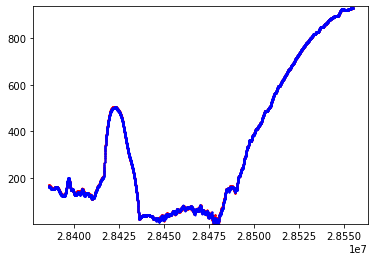

In [6]:
D6.plot()

ATL11 is similar.  The _ATL11_ package is a module that has _data_ and _point_ classes.  The _data_ class is a general container that has a structure similar to an ATL06 file.  The _point_ class contains one reference point worth of ATL11 data, and has a range of functions needed to process ATL06 into ATL11, some of which we'll find useful.

Because of the first two cycles are marching to their own drummer, it doesn't make sense to generate a single set of ATL11s.  I've made one set of ATL11s with reference surfaces defined from cycle 1 of the data, and another from cycle 2.  Let's look at one of these:

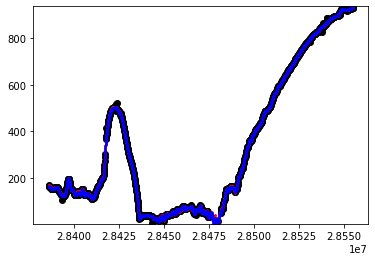

In [8]:
ATL11_file= "/home/jovyan/ATL11/cycle2/ATL11_0591_10__209_01.h5"
ATL06_ref_file="/home/jovyan/ATL11/processed_ATL06_20190205041106_05910210_001_01.h5"
D11=ATL11.data().from_file(ATL11_file)

# D11 has x_atc values and height values, but they're a couple of levels down in the structure:
plt.plot(D11.ref_surf.ref_pt_x_atc, D11.corrected_h.cycle_h_shapecorr,'ko')
D6.plot()

The ATL11 has data almost everywhere the ATL06 did, but there are a few places where the surface got too rough or the slopes were not consistent enough between segments, and the fitting failed.  

Let's have a quick look at the structure of D11:

In [9]:
dir(D11)

['DOPLOT',
 'Data',
 'N_coeffs',
 'N_cycles',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'all_fields',
 'corrected_h',
 'crossing_track_data',
 'cycle_stats',
 'from_file',
 'from_list',
 'get_xovers',
 'get_xy',
 'groups',
 'index',
 'pair_num',
 'plot',
 'poly_exponent',
 'ref_surf',
 'slope_change_t0',
 'track_num',
 'write_to_file']

Some of the items in the directory for D11 are data groups, some are functions.  We're going to use some data from the corrected_h group, and some from the ref_surf group

In [ ]:
dir(D11.crossing_track_data)

Since we don't have repeat data, let's look at how ATL11 handles crossovers.  This is the same set of operations that would be used for a repeat cycle that did not pass the quality checks, usually because only the strong beam provided good-quality data.  I have provided one ALT06 from rgt 523, cycle 1, so let's see how it appears in the ATL11 from rgt 591.  First, let's find all the reference points in the ATl11 data that might be involved in a crossover.

In [6]:
# First, find find the reference points in the rgt-591 ATL11 
# that are involved in a crossover with rgt 523
crossing_ind=np.where(D11.crossing_track_data.rgt_crossing==523)[0]
ref_pts_for_xover=D11.crossing_track_data.ref_pt_number[crossing_ind]
pair_nums_for_xover=D11.crossing_track_data.pt_crossing[crossing_ind]

print(ref_pts_for_xover)
print(pair_nums_for_xover)

[1424360. 1424365. 1424370. 1424375. 1424380. 1424385. 1424390. 1424395.
 1424400. 1424405. 1424410. 1424830. 1424835. 1424840. 1424845. 1424850.
 1424855. 1424860. 1424865. 1424870. 1424875. 1424905. 1424910. 1424915.
 1424920. 1424925. 1424930. 1424935. 1424940. 1424945. 1424950. 1424955.
 1425375. 1425380. 1425385. 1425390. 1425395. 1425400. 1425405. 1425410.
 1425415. 1425420. 1425450. 1425455. 1425460. 1425465. 1425470. 1425475.
 1425480. 1425485. 1425490. 1425495. 1425500. 1425925. 1425930. 1425935.]
[3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]


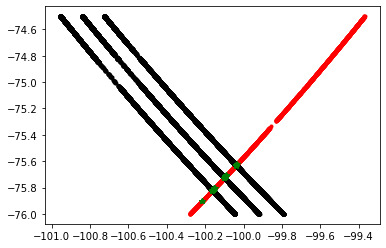

In [11]:
ATL06_crossing_file='/home/jovyan/ATL11/processed_ATL06_20181101215251_05230112_001_01.h5'

plt.figure()
plt.plot(D11.corrected_h.ref_pt_lon, D11.corrected_h.ref_pt_lat, 'r.')
for pair in [1, 2, 3]:
    D6=ATL06_data(beam_pair=pair).from_file(ATL06_crossing_file)
    plt.plot(D6.longitude, D6.latitude,'k.')

D11_crossing_ind=np.in1d(D11.corrected_h.ref_pt_number, ref_pts_for_xover)
plt.plot(D11.corrected_h.ref_pt_lon[D11_crossing_ind], D11.corrected_h.ref_pt_lat[D11_crossing_ind],'g*')
    

Let's pick the first of the reference points that has a crossover and plot the elevations for both tracks

In [12]:
this_pt_ind=np.where(D11.corrected_h.ref_pt_number==ref_pts_for_xover[0])[0]

# turn the ATL11 data from that point into an ATL11.point object (allows a lot of code to be used)
P11=ATL11.point().from_data(D11, this_pt_ind)

# for shorthand, pull out the coordinates of P11
x0 = P11.ref_surf.ref_pt_x_atc 
y0 = P11.ref_surf.ref_pt_y_atc
# and pull out the reference surface elevation
z0 = P11.corrected_h.cycle_h_shapecorr[0,1]

# read in the ATL06 data from the reference-track file
D_06=ATL06_data(beam_pair=2).from_file(ATL06_ref_file)

#select the ATL06 data that seg IDs within +-5 of this ATL11 center
D_06.index(np.abs(D_06.segment_id[:,0]-P11.ref_surf.ref_pt_number)<=5);


Now read the crossing-track data, and calculate the coordinates of its points in the reference-track coordinate system:

In [13]:
# the first crossing point was with beam pair 3; read this from the ATL06 file
D_06x=ATL06_data(beam_pair=3).from_file(ATL06_crossing_file)

# convert the crossing track coordinates into the RGT coordinates for track 523
# first, convert to local northing and easting  
E_x, N_x = P11.local_NE_coords(D_06x.latitude, D_06x.longitude)
# second, convert northing ane easting to x_ATC and y_ATC 
# note that this x_atc, y_atc is centered at the reference point 
x_ATC_x, y_ATC_x = P11.local_atc_coords(E_x, N_x)
# pick the points that are within a 150-meter circle
near=np.any((x_ATC_x**2+y_ATC_x**2)< 150**2, axis=1);

# subset the crossover data to points that are near enough
D_06x.index(near)
x_ATC_x=x_ATC_x[near,:]
y_ATC_x=y_ATC_x[near,:]

Now make a map of the reference and crossing tracks in the reference-track coordinate system

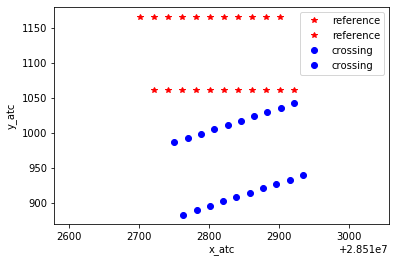

In [14]:
plt.figure()
plt.plot(D_06.x_atc, D_06.y_atc,'r*', label='reference')
plt.plot(x_ATC_x+x0, y_ATC_x+y0,'bo', label='crossing')
plt.axis('equal');
plt.xlabel('x_atc');
plt.ylabel('y_atc');
plt.legend()

This is not what would ordinarily be called a crossover, but if there were more repeats of the reference track, there would be a better chance that the 150-meter search radius used to find the points on the crossing  would include a better overlap of reference and crossing tracks. In any case, the propagated error on the reference surface still lets us evaluate the error incurred by a non-precise crossover like this one. Let's look at reference surface:

In [14]:
# define an array of points at which we'll calculate the reference-surface error
dx, dy = np.meshgrid(np.arange(-200, 200, 10), np.arange(-200, 200, 10))
dx=dx.ravel()
dy=dy.ravel()
# use the evaluate_reference_surf function of P11 to calculate the errors:
zref, zref_sigma=P11.evaluate_reference_surf(x0+dx, y0+dy, np.zeros_like(dx))

h_range=[np.min(zref.ravel()+z0), np.max(zref.ravel()+z0)]
plt.figure()
plt.scatter(D_06.x_atc, D_06.y_atc, c=D_06.h_li, marker='*', vmin=h_range[0], vmax=h_range[1])
plt.scatter(x_ATC_x+x0, y_ATC_x+y0, c=D_06x.h_li, marker='o', vmin=h_range[0], vmax=h_range[1])
plt.scatter(x0+dx, y0+dy, c=zref+z0, linewidth=0, marker='.', vmin=h_range[0], vmax=h_range[1])
plt.colorbar()
plt.title('heights')

We can use more-or-less the same strategy to map the error estimates for the data points and for the reference surface.  We'll calculate the total error for the crossing-track points, and find the point with the smallest error (including the error on the reference surface).  This is the point that ATL11 will use to represent the crossover in the output file.

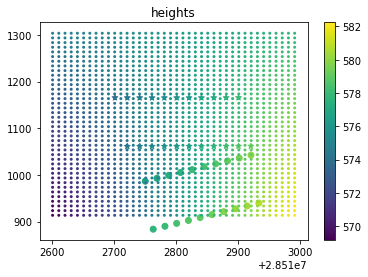

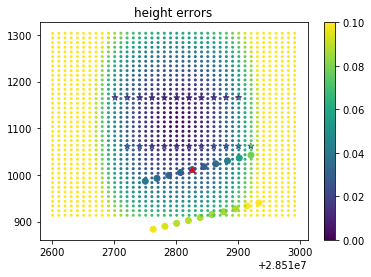

In [14]:
# reference surface and its errors evaluated at the crossing-point locaitons:

zref_x, zref_sigma_x=P11.evaluate_reference_surf(x0+x_ATC_x, y0+y_ATC_x, None)

# calculate the total error for the crossover points
sigma_xover_pts=np.sqrt(zref_sigma_x**2 + D_06x.h_li_sigma.ravel()**2)

# the point that's used to represent the crossover track in the data file is the one with the smallest 
# error estimate:
best=np.argmin(sigma_xover_pts)


sigma_range=[0, 0.1]
plt.figure()
plt.scatter(D_06.x_atc, D_06.y_atc, c=D_06.h_li_sigma, marker='*', vmin=sigma_range[0], vmax=sigma_range[1])
plt.scatter(x_ATC_x.ravel()+x0, y_ATC_x.ravel()+y0, c=sigma_xover_pts, marker='o', vmin=sigma_range[0], vmax=sigma_range[1])
plt.scatter(x0+dx, y0+dy, c=zref_sigma, linewidth=0, marker='.', vmin=sigma_range[0], vmax=sigma_range[1])
plt.plot(x_ATC_x.ravel()[best]+x0, y_ATC_x.ravel()[best]+y0,'r*')
plt.colorbar()
plt.title('height errors');

The crossover point with the minimum error is, somewhat surprisingly, not the one that's closest to a reference-track point.  Instead, it's the one closest to the reference point center, with the least-uncertain correction.

## 2. Crossover elevation changes for the Pine Island Glacier!

The ATL11.data class has one more handy tool.  It can return a structure containing its own crossover data in a form that's relatively easy to work with.


In [18]:
import glob

# Grab a piece of software that can hold groups of points and do geographic
# transforms on them.  
from PointDatabase import point_data

# need to use a regular expression to capture the rgt from the file name:
# this is just an object that looks at a file called "ATL11_0203_" and tells
# you that it's from rgt 203
file_re=re.compile('ATL11_(\d+)_')

xover_differences=[]
# loop over processed ATL11 files
for file in glob.glob('/home/jovyan/ATL11/cycle2/*.h5'):
    # pull the rgt number out of each file
    rgt=int(file_re.search(file).group(1))
    # loop over pairs
    for pair in [1, 2, 3]:
        # wrap the data reading in a try: because all three pairs might not be present
        try:
            # read the ATL11 data
            D11=ATL11.data(pair).from_file(file)
            # get the crossover data.  "delta" hold the crossover differences, 
            # "ref" and "crossing" hold reference track and crossing-track parameters
            ref, crossing, delta=D11.get_xovers(rgt, pair)
            # filter out some bad values (based on the ATL06 quality summary  
            # and the segment difference filter on the crossing track)
            ref.index((crossing.atl06_quality_summary==0) & (crossing.RSSz < 1))
            xover_differences.append(delta)
        except KeyError:
            pass

# make the list of crossover differences into point_data object.
#  We're doing this because point_data knows how to do geographc coordinate transforms
delta=point_data().from_list(xover_differences)

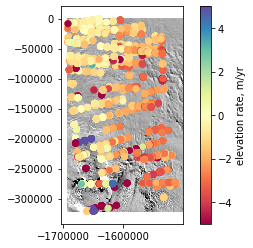

In [19]:
# read another piece of my code that you are absolutely welcome to use
from PointDatabase.mapData import mapData
MOA=mapData().from_geotif('/home/jovyan/ATL11/MOA_PIG_subset.tif')

# tell the 
delta.get_xy(EPSG=3031)

plt.figure()
plt.imshow(MOA.z, extent=MOA.extent, cmap='gray', vmin=14000, vmax=17000)
dh_dt=delta.h/(delta.time/24/3600/365)
dh_dt_sigma=delta.sigma_h/np.abs(delta.time/24/3600/365)
# select the crossovers for which the elevation rate error is smallish (< 0.5 m/yr)
good=dh_dt_sigma < .5
sc=plt.scatter(delta.x[good], delta.y[good], c=dh_dt[good], vmin=-5, vmax=5, cmap='Spectral')
cb=plt.colorbar(sc)
cb.set_label('elevation rate, m/yr')

This, believe it or not, is a pretty reasonable elevation-change map for the Pine Island Glacier.  There is a hole in the map because the weather was cloudy on a few days, and there are a few bad points that stand out because of the way we've plotted this.  But just wait.  This will look a lot better, soon.